# Amazon Product Analysis from SmartScout

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import base64
from typing import Union, Optional, Callable

# plt config
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15, 10)

import swifter  # parallelize pandas operations

# needed for CNN
import tensorflow as tf
from io import BytesIO
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 25)

## Import Data

In [3]:
dfs = {}
sample_csv_path = Path(r"E:\smartscout\21-Appliances.csv")

with sample_csv_path.open('r', encoding='utf-8') as fp:
    dfs['Appliances'] = pd.read_csv(fp)

In [4]:
dfs['Appliances'].head(5)

,brandId,subcategoryId,imageUrl,asin,title,brandName,categoryId,subcategory.subcategoryName,rank,amazonIsr,numberOfSellers,isVariation,monthlyRevenueEstimate,ttm,monthlyUnitsSold,listedSince,reviewCount,reviewRating,numberFbaSellers,buyBoxPrice,averageBuyBoxPrice,buyBoxEquity,revenueEquity,marginEquity,outOfStockNow,productPageScore,manufacturer,upc,partNumber,model,numberOfItems,totalRatings,momGrowth,momGrowth12,note
0,181347,2.399939e+09,data:image/jpeg;base6...,B09ZRNP19N,GE Profile Opal 1.0 N...,GE PROFILE,21,Ice Makers,NaN,0.0,1,False,3223122.00,890585.53,8078.0,2022-05-07T00:00:00,2667,4.3,1,399.00,306.50,4039.0,1611561.00,241734.15,False,9.2,GE Profile,8.469190e+10,P4INAASSTSS,P4INAASSTSS,1,0.0,-0.770,NaN,NaN
1,297220,3.741161e+06,data:image/jpeg;base6...,B0C7M5MKDQ,Maxblue RPWFE (with C...,Maxblue,21,Water Filters,NaN,0.0,1,False,474807.34,NaN,3466.0,2023-06-10T00:00:00,3528,NaN,1,136.99,68.00,1733.0,237403.67,35610.55,False,7.2,Maxblue,NaN,MB-F19C-D,MB-F19C-D,1,NaN,NaN,NaN,NaN
2,12164,2.399939e+09,data:image/jpeg;base6...,B0BTHNM6V7,AGLUCKY Ice Makers Co...,AGLUCKY,21,Ice Makers,3.0,0.0,1,True,277056.91,1335114.83,2309.0,2023-01-31T00:00:00,21845,4.3,1,119.99,92.32,1154.5,138528.45,20779.27,False,9.1,AGLUCKY,NaN,FBA-Z5878-GREEN,NaN,1,NaN,0.000,NaN,NaN
3,138140,2.399939e+09,data:image/jpeg;base6...,B0BV9Z8ZFV,EUHOMY Countertop Ice...,E EUHOMY,21,Ice Makers,6.0,0.0,1,True,273286.23,686804.59,2877.0,2023-02-09T00:00:00,1716,4.4,1,94.99,94.99,1438.5,136643.11,20496.47,False,9.0,E EUHOMY,1.968528e+11,HZB-12H,IM-06S-HM,1,NaN,-0.660,NaN,NaN
4,138140,2.399939e+09,data:image/jpeg;base6...,B0BWHZJHPL,EUHOMY Countertop Ice...,E EUHOMY,21,Ice Makers,NaN,0.0,1,False,258901.23,292219.75,2877.0,2023-02-22T00:00:00,1716,4.4,1,89.99,52.24,1438.5,129450.61,19417.59,False,9.0,E EUHOMY,1.976442e+11,IM-06D-HM,IM-06D-HM,1,NaN,-0.138,NaN,NaN


## Massaging data into a workable state

### Declare Functions

In [5]:
def run_on_all(function: Callable[[pd.DataFrame], Optional[pd.DataFrame]]) -> None:
    global dfs

    for category_name, category_df in dfs.items():
        function(category_df)

### Clean Data

In [6]:
def clean_data(df: pd.DataFrame) -> None:
    df.drop(columns=['brandId', 'subcategoryId', 'asin', 'categoryId', 'rank', 'amazonIsr', 'ttm', 'listedSince', 'reviewCount', 'reviewRating', 'numberFbaSellers', 'averageBuyBoxPrice', 'buyBoxEquity', 'revenueEquity', 'marginEquity', 'outOfStockNow', 'productPageScore', 'upc', 'partNumber', 'numberOfItems', 'totalRatings', 'momGrowth', 'momGrowth12', 'note', 'model'], inplace=True)
    # df.rename(columns={'brandName': 'brand', 'subcategory.subcategoryName': 'subcategory', 'monthlyRevenueEstimate': 'revenue', 'buyBoxPrice': 'price'}, inplace=True)
    df.rename(columns={"subcategory.subcategoryName": "subcategoryName"}, inplace=True)
    
    # Check for duplicates
    print('Length of data:', len(df))
    duplicates = df.duplicated('title')
    print(len(df[duplicates]), ' Duplicates Found, dropping...')
    df.drop_duplicates(subset=['imageUrl', 'title'], inplace=True)

run_on_all(clean_data)

Length of data: 23084
2372  Duplicates Found, dropping...


In [7]:
dfs['Appliances'].head(5)

,imageUrl,title,brandName,subcategoryName,numberOfSellers,isVariation,monthlyRevenueEstimate,monthlyUnitsSold,buyBoxPrice,manufacturer
0,data:image/jpeg;base6...,GE Profile Opal 1.0 N...,GE PROFILE,Ice Makers,1,False,3223122.00,8078.0,399.00,GE Profile
1,data:image/jpeg;base6...,Maxblue RPWFE (with C...,Maxblue,Water Filters,1,False,474807.34,3466.0,136.99,Maxblue
2,data:image/jpeg;base6...,AGLUCKY Ice Makers Co...,AGLUCKY,Ice Makers,1,True,277056.91,2309.0,119.99,AGLUCKY
3,data:image/jpeg;base6...,EUHOMY Countertop Ice...,E EUHOMY,Ice Makers,1,True,273286.23,2877.0,94.99,E EUHOMY
4,data:image/jpeg;base6...,EUHOMY Countertop Ice...,E EUHOMY,Ice Makers,1,False,258901.23,2877.0,89.99,E EUHOMY


### Display Data

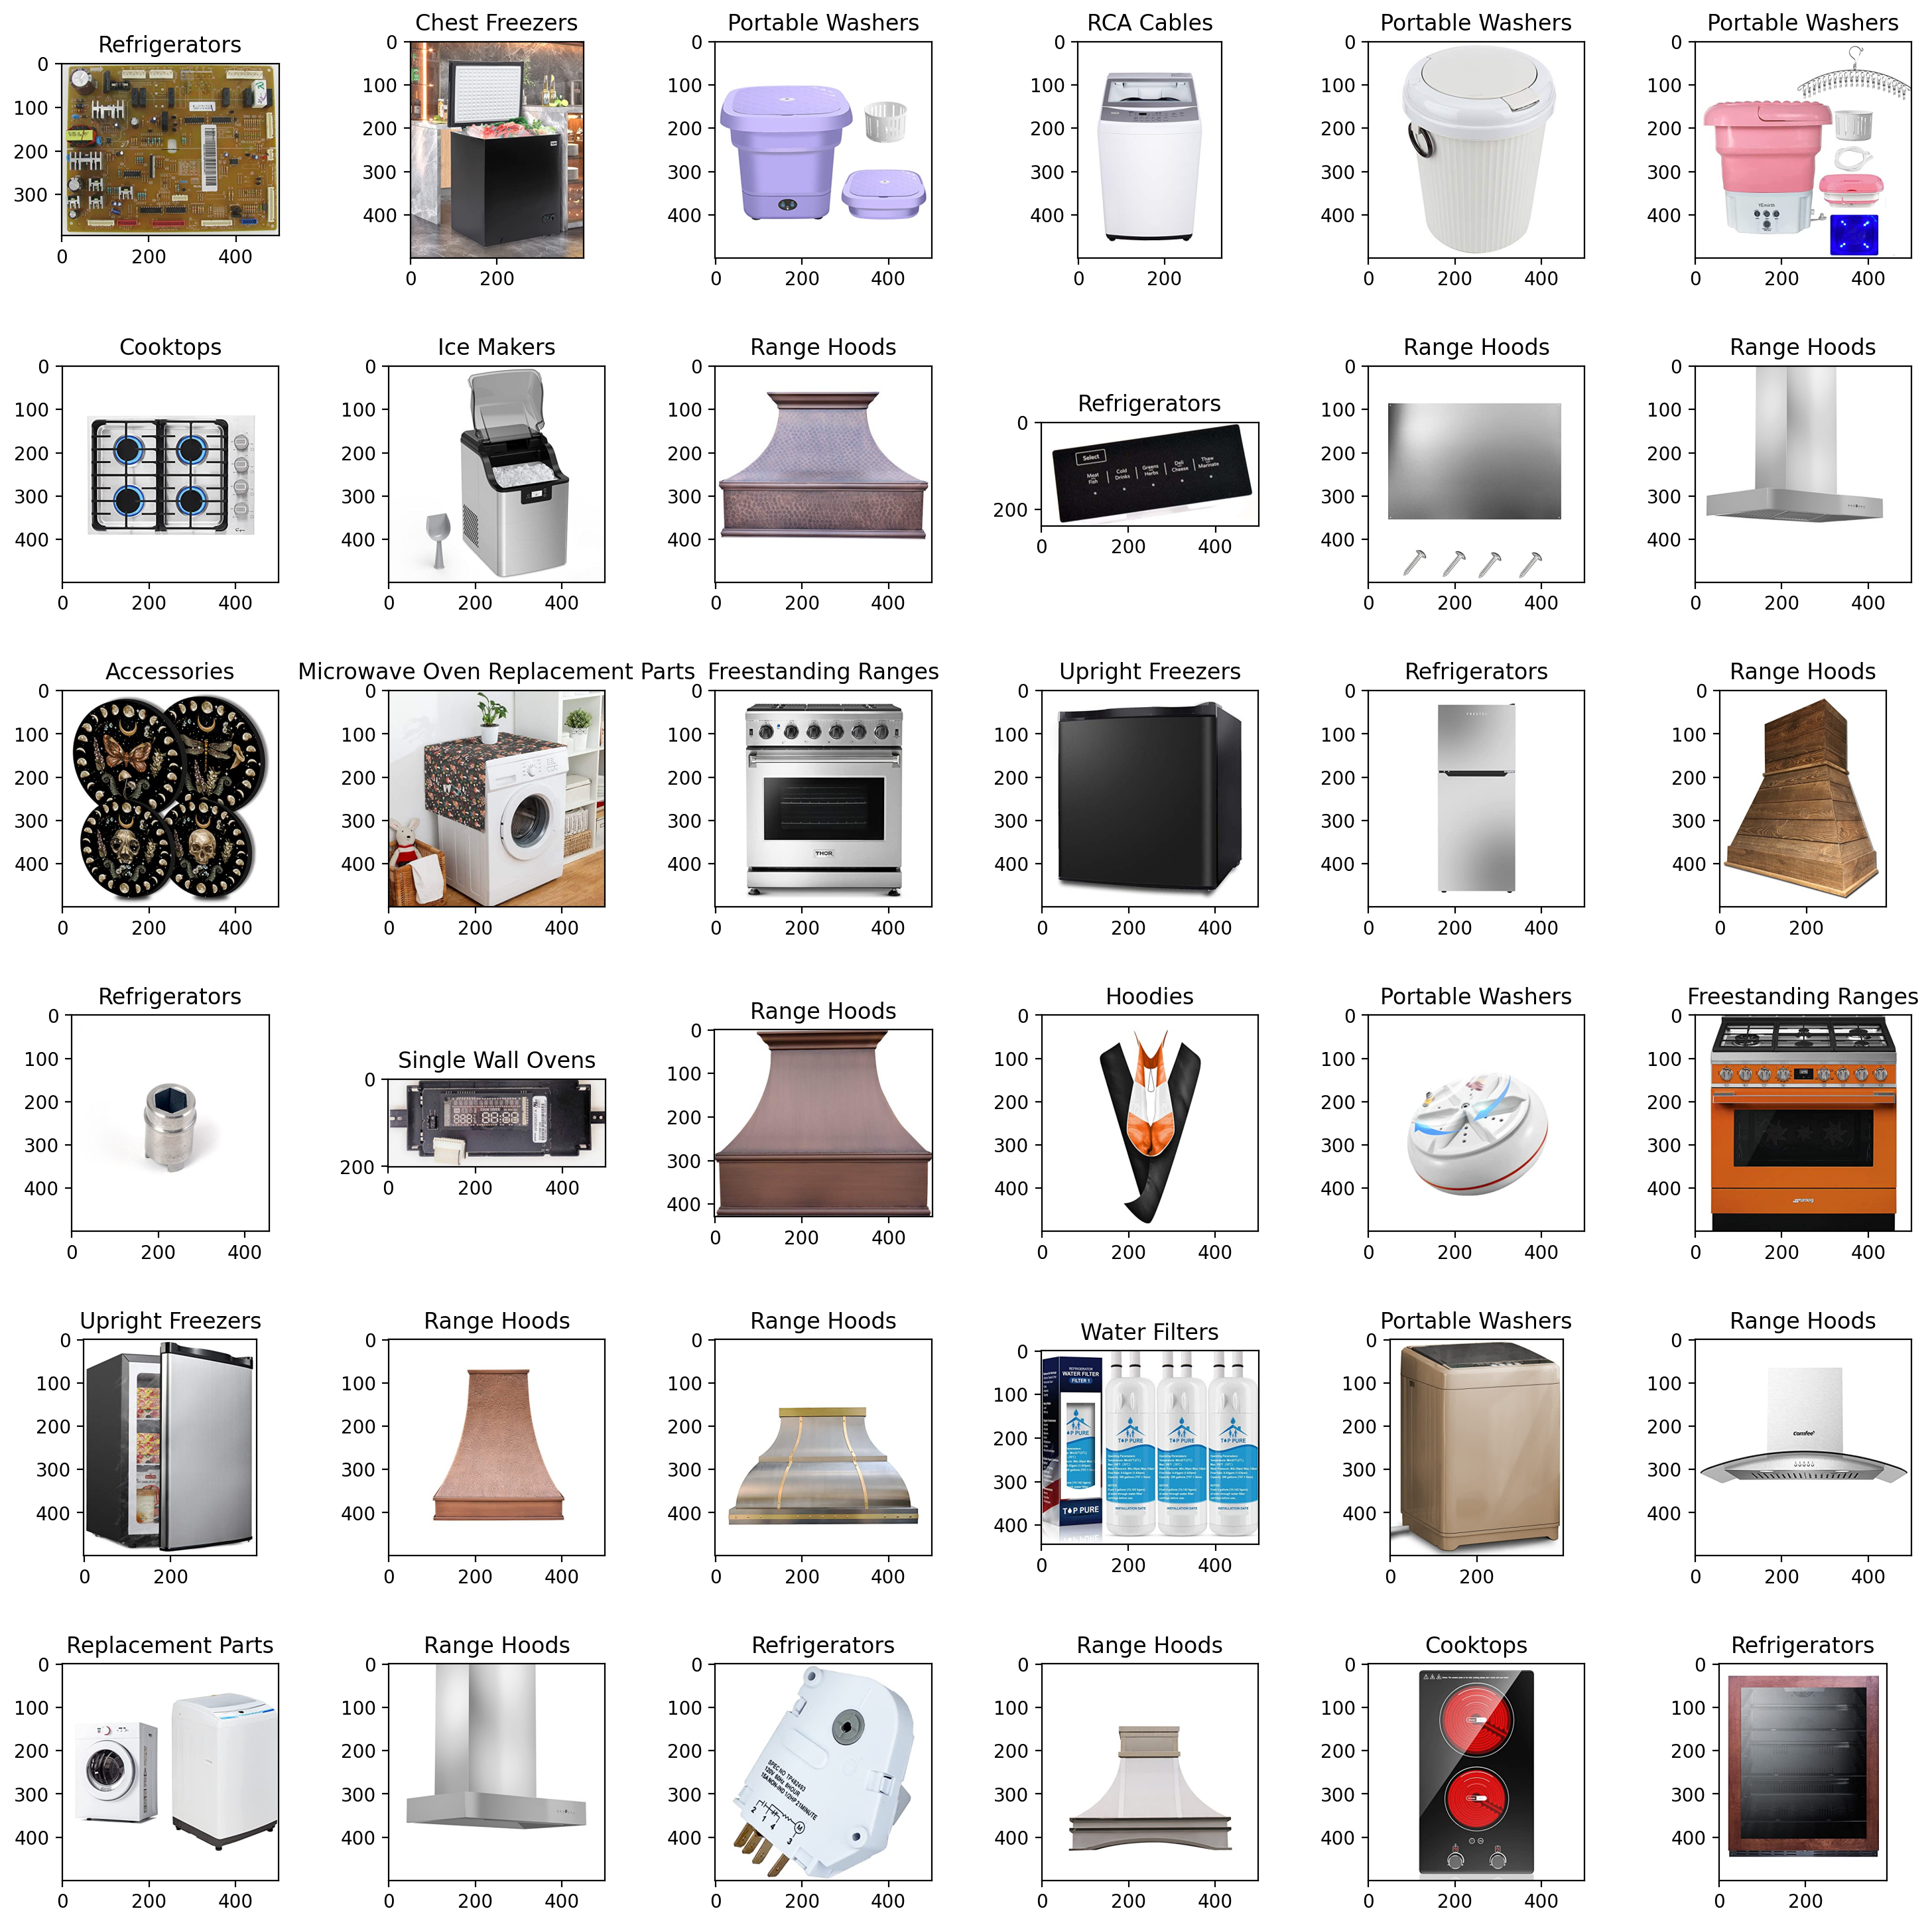

In [8]:
def display_products(df: pd.DataFrame) -> None:
    data = df[["subcategoryName", "imageUrl"]].copy()
    data.dropna(inplace=True)

    n = 6
    random_integers = np.random.randint(0, len(data), size=n**2)
    fig, axes = plt.subplots(n, n, figsize=(n*3, n*3))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)


    for i, ax in enumerate(axes.flat):
        subcategory = data.iloc[random_integers[i], 0]
        url = data.iloc[random_integers[i], 1]

        image_format = url.split(';')[0].split(':')[1]  # image/jpeg
        img_bytes = base64.b64decode(url.split(',')[1])

        format_plt_map = {
            'image/jpeg': 'jpg',
            'image/png': 'png',
            'image/gif': 'gif',
        }
        try:
            plt_format = format_plt_map[image_format]
        except KeyError:
            # not worth it
            continue

        with BytesIO(img_bytes) as img_fp:
            plt_img = plt.imread(img_fp, format=plt_format)
            ax.imshow(plt_img, cmap='gray')  # You can adjust the colormap if needed
            ax.set_title(subcategory)

run_on_all(display_products)

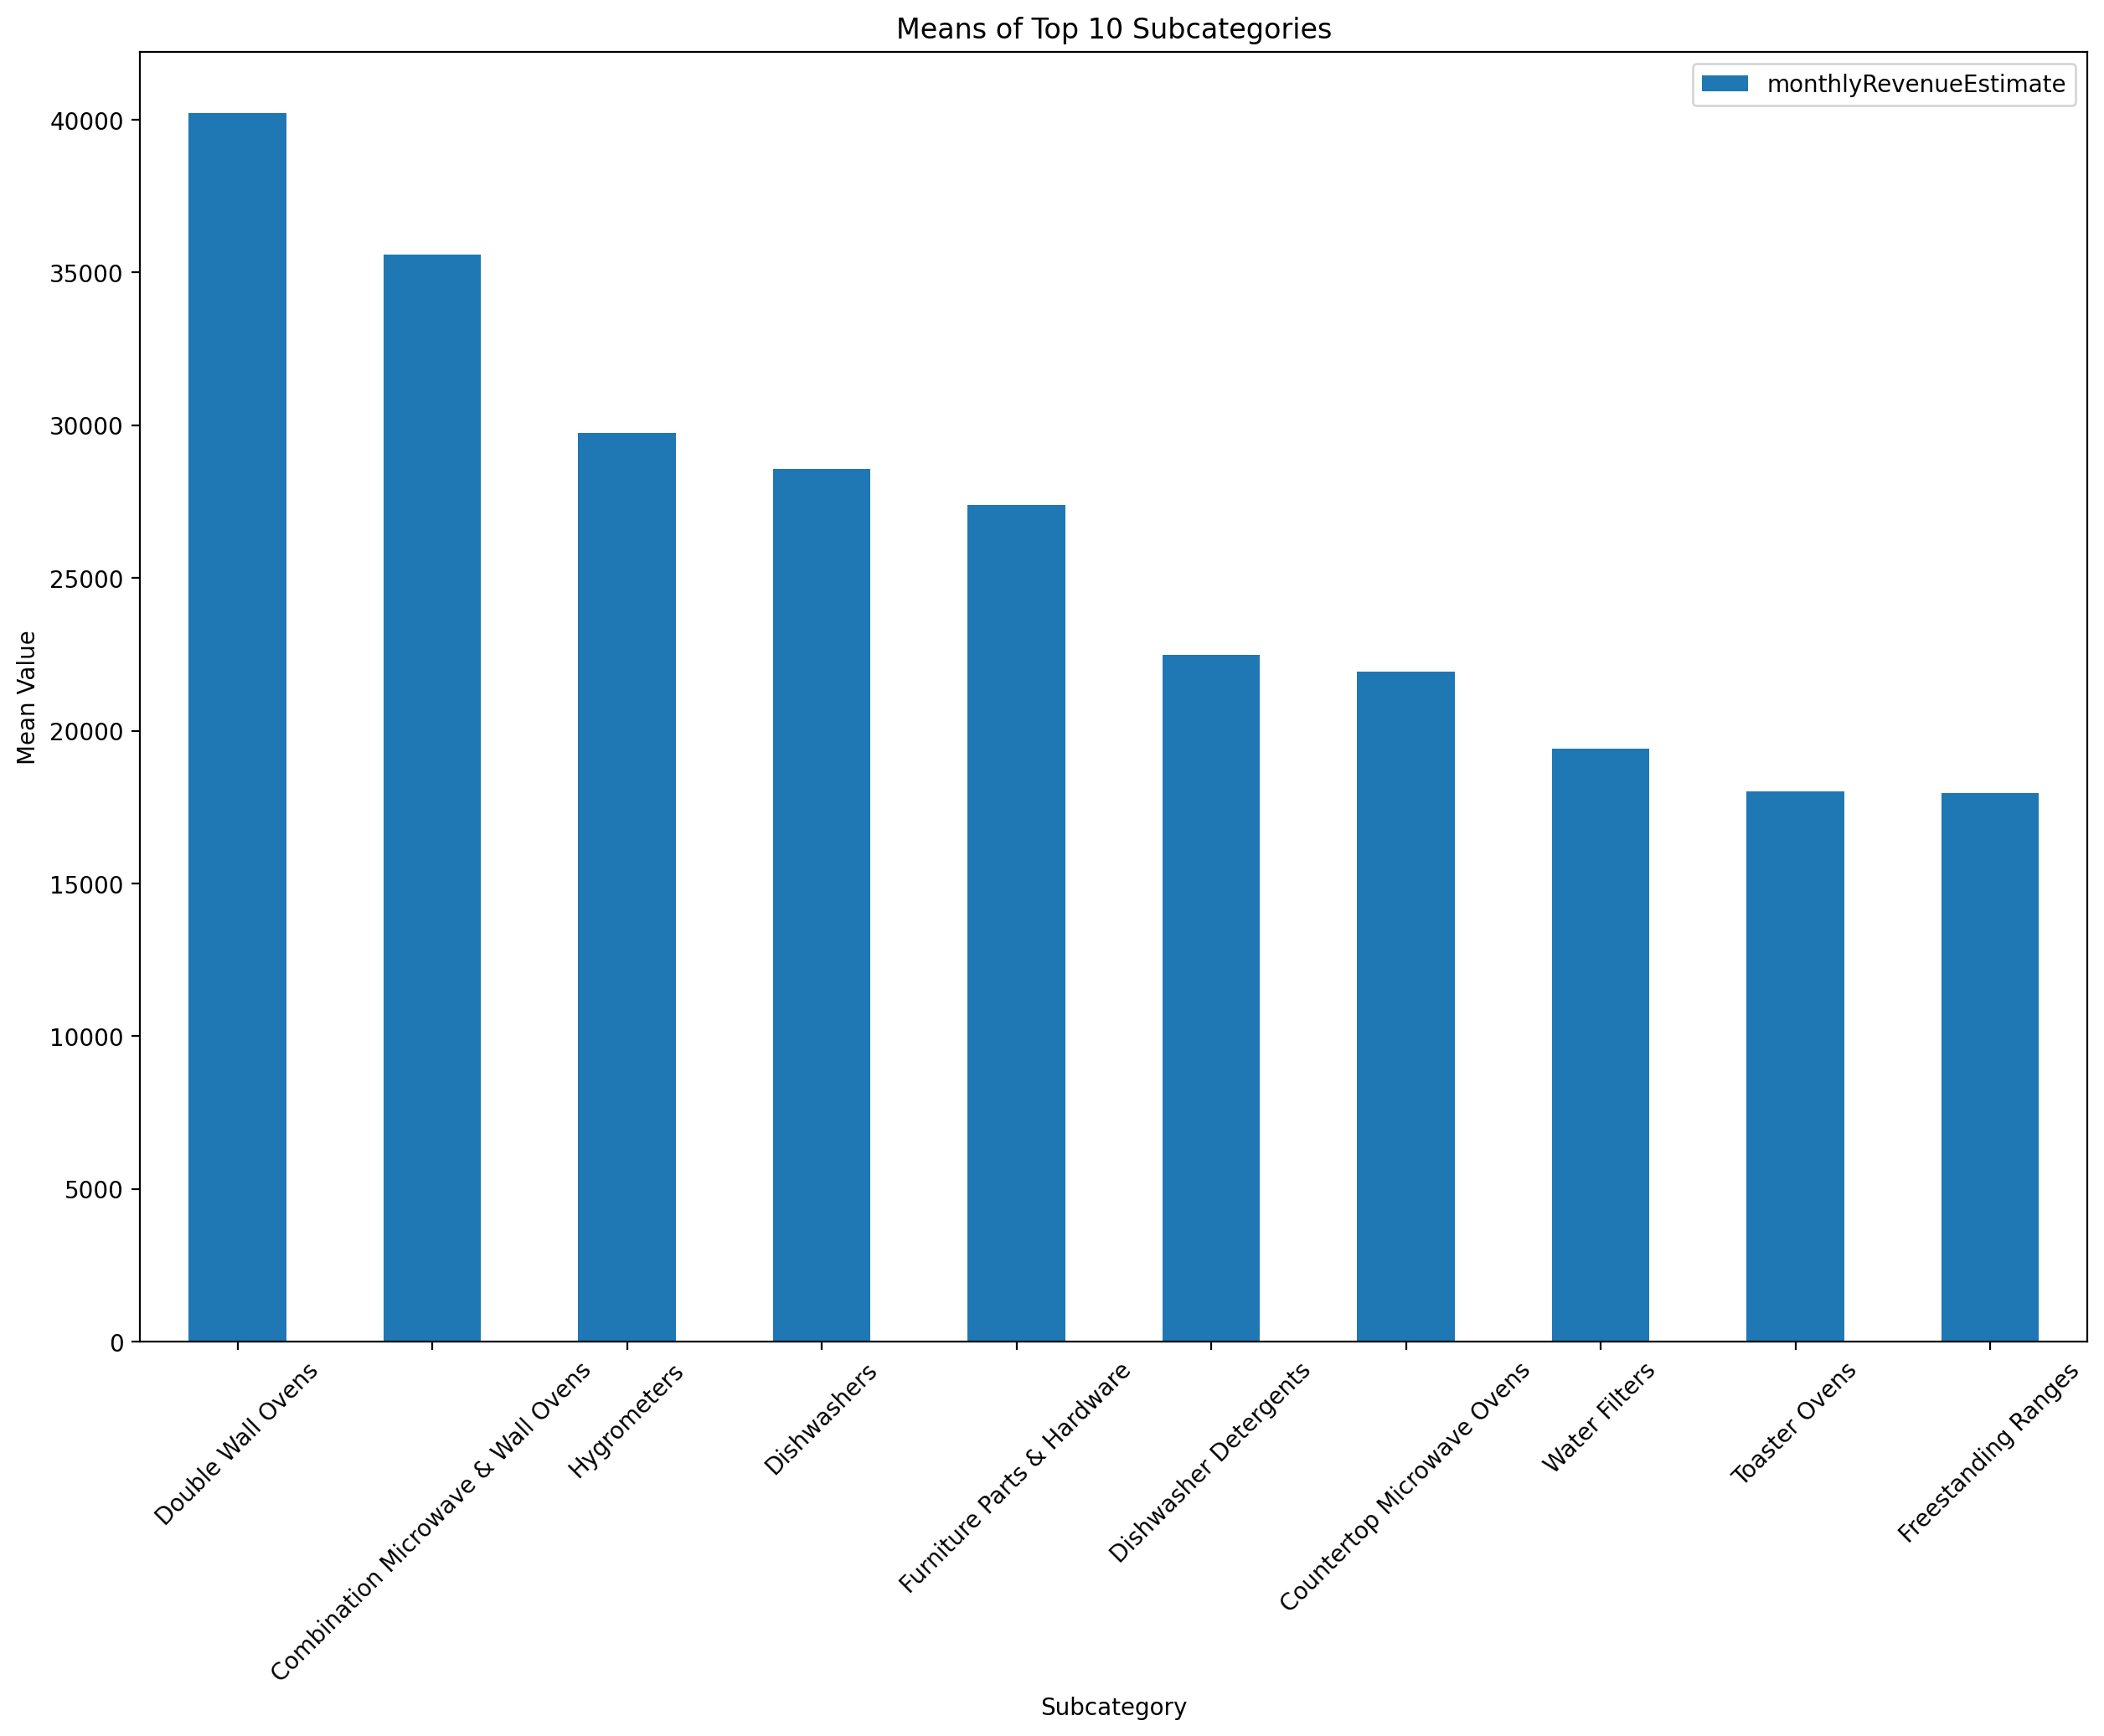

In [9]:
def display_means(df: pd.DataFrame) -> None:
    data = df[["subcategoryName", "monthlyRevenueEstimate"]].copy()
    data.dropna(inplace=True)

    grouped = data.groupby(['subcategoryName'])['monthlyRevenueEstimate'].mean().reset_index().sort_values('monthlyRevenueEstimate', ascending=False)
    
    n = 10
    top_subcategories = grouped['subcategoryName'].head(n)
    grouped = grouped[grouped['subcategoryName'].isin(top_subcategories)]
    
    grouped.plot(x='subcategoryName', y='monthlyRevenueEstimate', kind='bar', rot=45)
    
    plt.xlabel('Subcategory')
    plt.ylabel('Mean Value')
    plt.title('Means of Top {} Subcategories'.format(n))
    plt.show()

run_on_all(display_means)

## Converting Image URIs into workable numpy arrays

In [10]:
# this may not be enough data, but we will see
IMAGE_X = 224
IMAGE_Y = 224


def base64_to_array(base64_data: Union[Optional[str], float]) -> Optional[np.ndarray]:
    if base64_data is None or isinstance(base64_data, float):
        return None

    # will be in format of data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAA...
    content_type = base64_data.split(';')[0].split(":")[0]  # image/jpeg  # PIL can assume this, so it's not passed any further
    image_data = base64_data.split(',')[1]  # Remove the 'data:image/jpeg;base64,' prefix
    # fmt: off
    with BytesIO(base64.b64decode(image_data)) as image_fp, \
            Image.open(image_fp) as image:
        # fmt: on

        # normalize color space
        image = image.convert('RGB')

        # fit image in an EXACTLY 224x224 box, leaving transparent space
        image = ImageOps.fit(image, (IMAGE_X, IMAGE_Y), Image.ANTIALIAS)
        image = image.resize((IMAGE_X, IMAGE_Y), Image.ANTIALIAS)

        # convert image to numpy array
        image_array = np.asarray(image)
        return image_array

def convert_image_urls_to_arrays(df: pd.DataFrame) -> None:
    df['imageData'] = df['imageUrl'].swifter.apply(base64_to_array)
    df.drop(columns=['imageUrl'])

run_on_all(convert_image_urls_to_arrays)

Pandas Apply:   0%|          | 0/21557 [00:00<?, ?it/s]

C:\Users\parke\AppData\Local\Temp\ipykernel_41868\1754178851.py:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = ImageOps.fit(image, (IMAGE_X, IMAGE_Y), Image.ANTIALIAS)
C:\Users\parke\AppData\Local\Temp\ipykernel_41868\1754178851.py:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((IMAGE_X, IMAGE_Y), Image.ANTIALIAS)


## Test #1: Estimating Sales from Images

### Selecting the columns of interest

In [11]:
# we DON'T want to copy the root dataframe, we just want to create a view into it so we save as much memory in the python process as possible
appliances = dfs["Appliances"]
data = appliances[['imageData', 'monthlyUnitsSold']].copy()  # only relevant columns

# Remove NaN Values
length_before_drop = len(data)
data.dropna(subset=['imageData', "monthlyUnitsSold"], inplace=True)
length_after_drop = len(data)
print(f'{length_before_drop-length_after_drop} nan rows dropped')

11928 nan rows dropped


### Converting the image URIs to image data

At this point in developing the code, it became apparent that memory was going to become a concern. Let's take a look at how much memory both of our dataframes are using.

In [12]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 9629 entries, 0 to 20985
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   imageData         9629 non-null   object 
 1   monthlyUnitsSold  9629 non-null   float64
dtypes: float64(1), object(1)
memory usage: 1.5 MB


OK, looks like we should be ok. Let's give it another shot.

### Convolutional Neural Network (CNN) Training

In [13]:
# Load the VGG16 model
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_X, IMAGE_Y, 3)
)

# Freeze the pre-trained layers
base_model.trainable = False

# Create a new model by adding custom layers on top of VGG16
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Convert revenue values to numpy array
sales_array = np.array(data['monthlyUnitsSold'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['imageData'], sales_array, test_size=0.2, random_state=42)

# Convert the image data arrays into TensorFlow-compatible format
X_train = np.stack(X_train.swifter.apply(preprocess_input))
X_test = np.stack(X_test.swifter.apply(preprocess_input))

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Pandas Apply:   0%|          | 0/7703 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1926 [00:00<?, ?it/s]

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.